Santander Customer Satisfaction

# Introdução

A satisfação do cliente é uma medida essencial do sucesso. Os clientes insatisfeitos raramente expressam sua insatisfação antes de sair. 

Nosso objetivo aqui é identificar os clientes insatisfeitos e com isso criar planos de ação, medidas, para melhorar a felicidade dos clientes

## Dataset

Sobre os dados, são dados os conjuntos de **treino** e de **teste**, as features do dataset são anônimas, sabendo que feature `TARGET` contém a classificação do cliente como satisfeito ou insatisfeito

```python
TARGET = 0 # satisfeito
TARGET = 1 # insatisfeito
```

## Objetivos

Temos aqui três objetivos principais

  1. Classificar os `positivos verdadeiros`, ou seja, o cliente que estava insatisfeito e foi alvo de uma ação de retenção
    - O benefício nesse caso é o lucro da ação ($R\$\ 100,00$) menos os custos relacionados à ação de retenção ($R\$\ 10,00$)
    
  2. Atribuir uma nota de 1 a 5 para cada cliente da base de `teste` respeitando a variável `TARGET`, isto é, o seu nível de satisfação, sendo 1 o mais insatisfeito e 5 o mais satisfeito
    - Ao atribuir essa nota, deve-se ter em mente que o somente os clientes com nota 1 serão alvos de uma ação de retenção e que o objetivo dessa ação é maximizar o lucro esperado pelo cliente.
    
  3. Agrupar em três grupos, onde teríamos os maiores lucros esperados por cliente

# Exploração dos dados

In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

## Estudo das variavéis

Como as colunas do nosso *dataset* não possuem descrição, vamos seguir uma abordagem de explorar os dados e com isso criar um primeiro modelo de classificação como `baseline`, para isso podemos construir alguns testes de escolha das `features`, como 
  - Univariate feature selection
  - Recursive feature elimination

### Distribuição do target
Observemos se um cliente possui mais de uma amostra no `dataset`

In [3]:
train.ID.shape[0]==len(train.ID.unique())

True

Como sabemos a que a `feature` `ID` é a chave que identifica o cliente, vamos observar como está a sua distribuição em relação a `feature` `TARGET`

In [4]:
(train.groupby('TARGET')['ID'].agg({'count'})['count']).apply(lambda x: x/train.shape[0])

TARGET
0    0.960431
1    0.039569
Name: count, dtype: float64

Apenas 3,96% dos clientes estão insatisfeitos

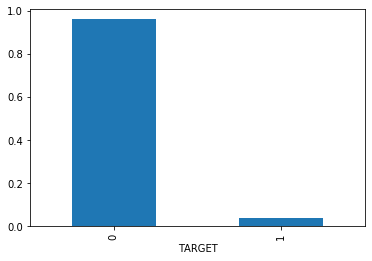

In [5]:
(train.groupby('TARGET')['ID'].agg({'count'})['count']).apply(lambda x: x/train.shape[0]).plot.bar();

### Agrupamento das variáveis

Como não sabemos os nomes das colunas, e encontramos um certo padrão em relação as variáveis, observe que existe um prefixo e um sufixo que compõe a variável. Vamos tentar agrupar essas variáveis pelo grupo à qual ela pertence. Por exemplo, a variável `var40` está segmentada em  subvariáveis

In [6]:
train.columns[train.columns.str.contains('var40')]

Index(['imp_op_var40_comer_ult1', 'imp_op_var40_comer_ult3',
       'imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3',
       'imp_op_var40_ult1', 'ind_var40_0', 'ind_var40', 'num_op_var40_hace2',
       'num_op_var40_hace3', 'num_op_var40_ult1', 'num_op_var40_ult3',
       'num_var40_0', 'num_var40', 'saldo_var40', 'num_op_var40_comer_ult1',
       'num_op_var40_comer_ult3', 'num_op_var40_efect_ult1',
       'num_op_var40_efect_ult3'],
      dtype='object')

#### Variavéis que não acompanham nenhum sufixo

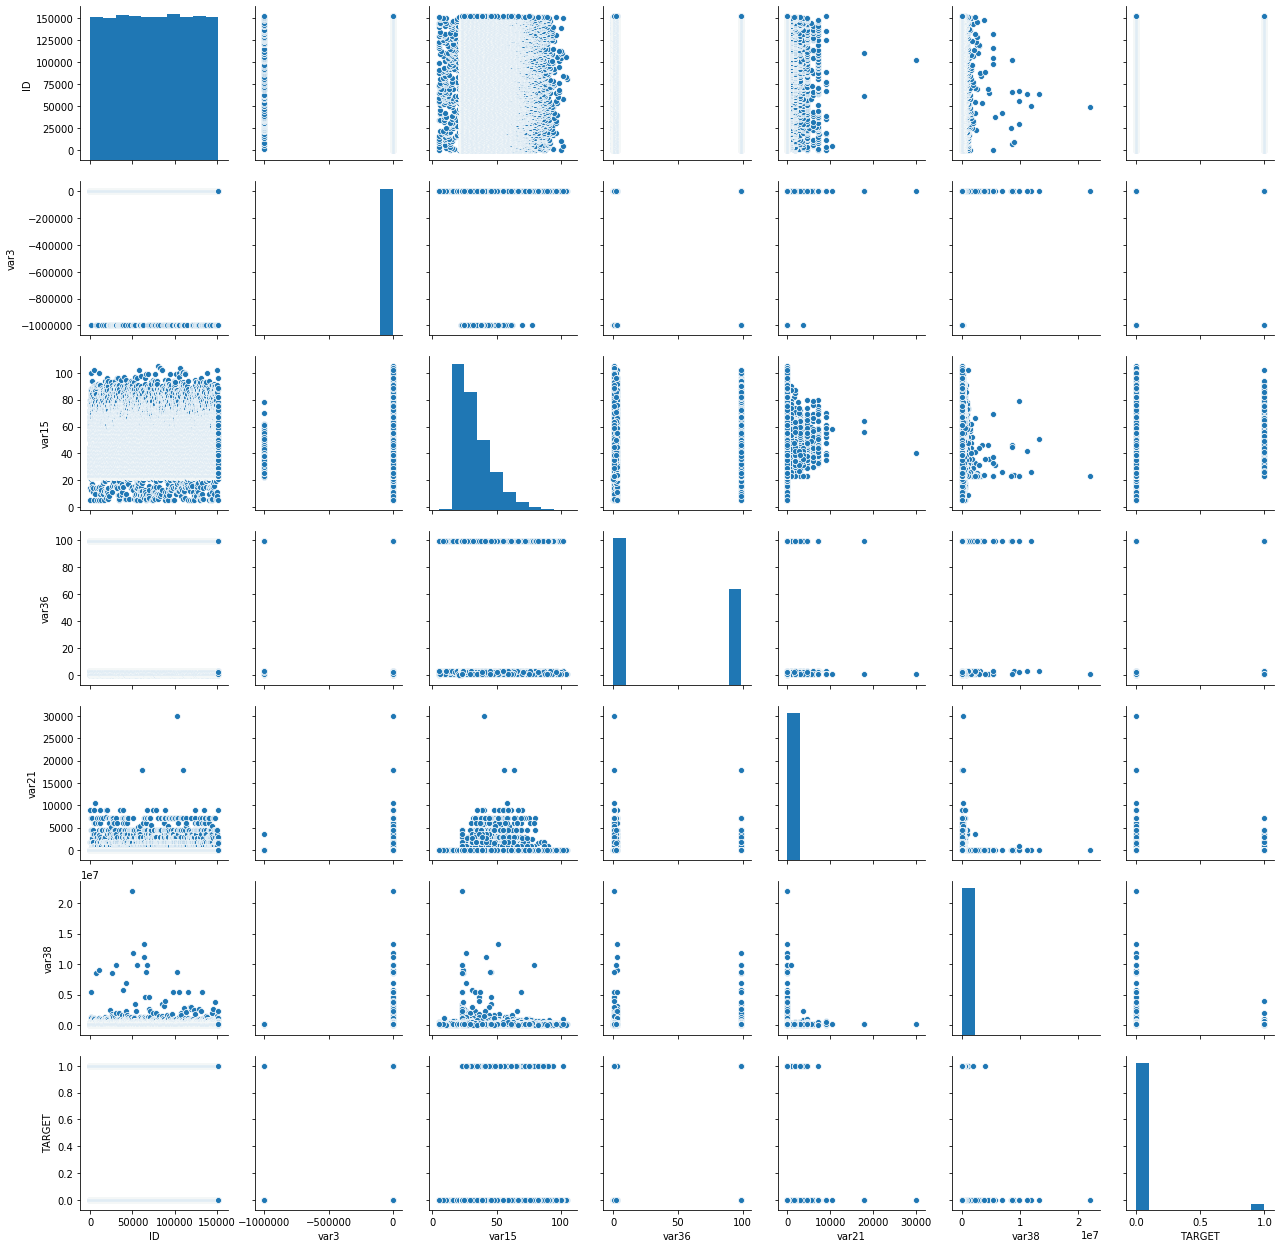

In [7]:
# apenas as `var`
sns.pairplot(train[train.columns[~train.columns.str.contains('.var*')]])

#result
# a var15 parece uma variavel de tempo, possui caracteristica de decaimento

Vamos observar a variância dessas features

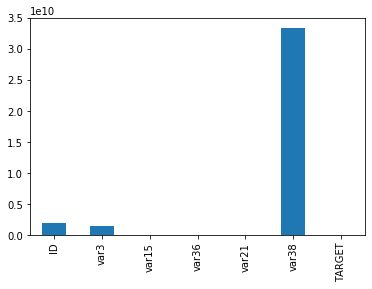

In [8]:
train[train.columns[~train.columns.str.contains('.var*')]].var().plot.bar(label='variância das features');

A `var38` possui a maior variância desse *subset* das features, algo com variância muito grande poderia indicar algum valor monetário, provavelmente, saldo em conta

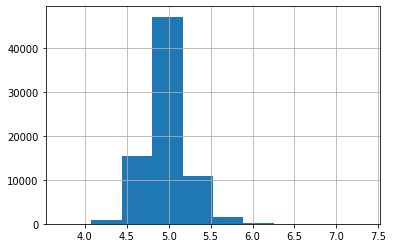

In [9]:
train.var38.map(np.log10).hist();

A distribuição é centrada aproximadamente em $10^5 \approx 100000$, que é um valor bem alto para conta corrente, vamos observar mais a frente...

Outro ponto a se observar, é a distribuição da feature `var15`, que provalvelmente seja idade do cliente

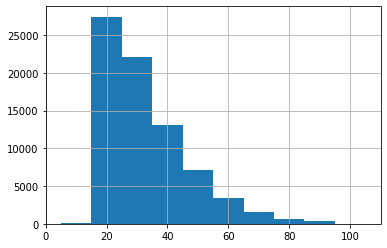

In [10]:
train.var15.hist();

#### Variavéis que acompanham sufixo

Anteriomente, olhamos para as variáveis que não foram quebradas em subcategorias, por assim dizer, variáveis "puras".

O que acontece se agruparmos novamente as variáveis que foram segmentadas para entender seu comportamento?

In [11]:
# as demais `var`
train[train.columns[train.columns.str.contains('var')]]

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000
76016,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000
76017,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000
76018,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000


In [153]:
var_names = pd.DataFrame(train.columns[train.columns.str.contains('var')], columns=['names'])

In [154]:
import re
r = re.compile("var")

var_names['group'] = var_names['names'].str.split('_').apply(lambda x: list(filter(r.match, x))[0])

O dataframe `var_names` possui a coluna `group` que indica a variável que foi segmentada

In [155]:
var_names

,names,group
0,var3,var3
1,var15,var15
2,imp_ent_var16_ult1,var16
3,imp_op_var39_comer_ult1,var39
4,imp_op_var39_comer_ult3,var39
...,...,...
364,saldo_medio_var44_hace2,var44
365,saldo_medio_var44_hace3,var44
366,saldo_medio_var44_ult1,var44
367,saldo_medio_var44_ult3,var44


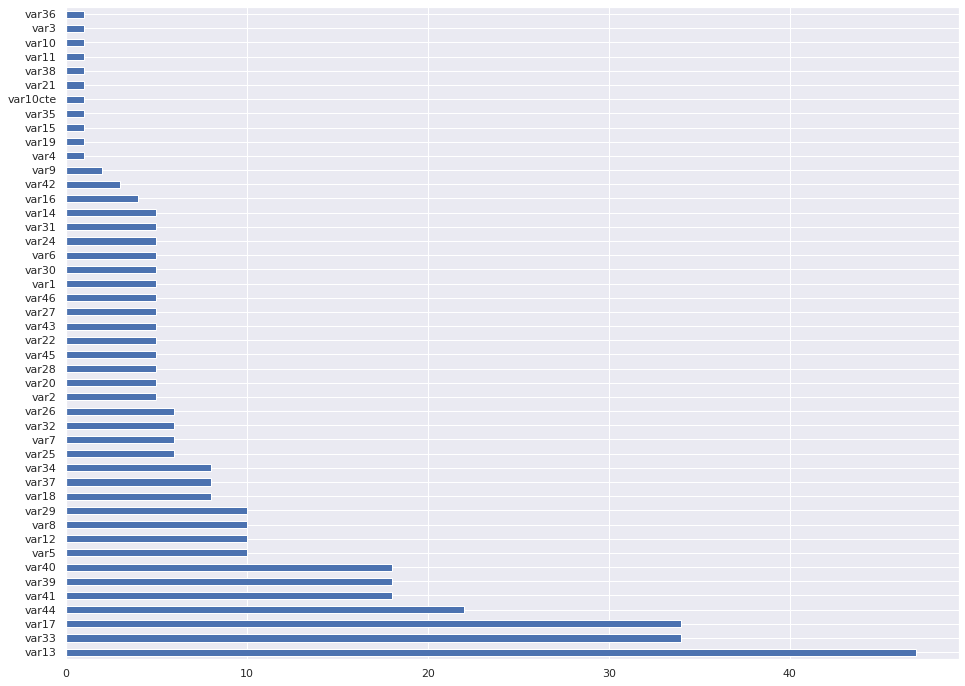

In [156]:
plt.figure(figsize=(16,12))
var_names.group.value_counts().plot.barh();

In [157]:
variaveis_count = var_names.group.value_counts()
np.sort(variaveis_count[variaveis_count==1].index)

array(['var10', 'var10cte', 'var11', 'var15', 'var19', 'var21', 'var3',
       'var35', 'var36', 'var38', 'var4'], dtype=object)

Nosso primeiro ponto aqui,
  - Variáveis que não são segmentadas provavelmente referem-se a informações do cliente, como idade, `var15`, ou alguma informação referente a cadastro
    - `var10`
    - `var10cte`
    - `var11`
    - `var15`
    - `var19`
    - `var21`
    - `var3`
    - `var35`
    - `var36`
    - `var38`
    - `var4`

In [17]:
grouped = var_names.groupby(['group','names']).count()
grouped

Empty DataFrame
Columns: []
Index: [(var1, ind_var1), (var1, ind_var1_0), (var1, num_var1), (var1, num_var1_0), (var1, saldo_var1), (var10, ind_var10_ult1), (var10cte, ind_var10cte_ult1), (var11, num_trasp_var11_ult1), (var12, ind_var12), (var12, ind_var12_0), (var12, num_meses_var12_ult3), (var12, num_var12), (var12, num_var12_0), (var12, saldo_medio_var12_hace2), (var12, saldo_medio_var12_hace3), (var12, saldo_medio_var12_ult1), (var12, saldo_medio_var12_ult3), (var12, saldo_var12), (var13, delta_imp_aport_var13_1y3), (var13, delta_imp_reemb_var13_1y3), (var13, delta_num_aport_var13_1y3), (var13, delta_num_reemb_var13_1y3), (var13, imp_aport_var13_hace3), (var13, imp_aport_var13_ult1), (var13, imp_reemb_var13_hace3), (var13, imp_reemb_var13_ult1), (var13, ind_var13), (var13, ind_var13_0), (var13, ind_var13_corto), (var13, ind_var13_corto_0), (var13, ind_var13_largo), (var13, ind_var13_largo_0), (var13, ind_var13_medio), (var13, ind_var13_medio_0), (var13, num_aport_var13_hace3), (var13, num_aport_var13_ult1), (var13, num_meses_var13_corto_ult3), (var13, num_meses_var13_largo_ult3), (var13, num_meses_var13_medio_ult3), (var13, num_reemb_var13_hace3), (var13, num_reemb_var13_ult1), (var13, num_var13), (var13, num_var13_0), (var13, num_var13_corto), (var13, num_var13_corto_0), (var13, num_var13_largo), (var13, num_var13_largo_0), (var13, num_var13_medio), (var13, num_var13_medio_0), (var13, saldo_medio_var13_corto_hace2), (var13, saldo_medio_var13_corto_hace3), (var13, saldo_medio_var13_corto_ult1), (var13, saldo_medio_var13_corto_ult3), (var13, saldo_medio_var13_largo_hace2), (var13, saldo_medio_var13_largo_hace3), (var13, saldo_medio_var13_largo_ult1), (var13, saldo_medio_var13_largo_ult3), (var13, saldo_medio_var13_medio_hace2), (var13, saldo_medio_var13_medio_hace3), (var13, saldo_medio_var13_medio_ult1), (var13, saldo_medio_var13_medio_ult3), (var13, saldo_var13), (var13, saldo_var13_corto), (var13, saldo_var13_largo), (var13, saldo_var13_medio), (var14, ind_var14), (var14, ind_var14_0), (var14, num_var14), (var14, num_var14_0), (var14, saldo_var14), (var15, var15), (var16, imp_ent_var16_ult1), (var16, imp_sal_var16_ult1), (var16, num_ent_var16_ult1), (var16, num_sal_var16_ult1), (var17, delta_imp_aport_var17_1y3), (var17, delta_imp_reemb_var17_1y3), (var17, delta_imp_trasp_var17_in_1y3), (var17, delta_imp_trasp_var17_out_1y3), (var17, delta_num_aport_var17_1y3), (var17, delta_num_reemb_var17_1y3), (var17, delta_num_trasp_var17_in_1y3), (var17, delta_num_trasp_var17_out_1y3), (var17, imp_aport_var17_hace3), (var17, imp_aport_var17_ult1), (var17, imp_reemb_var17_hace3), (var17, imp_reemb_var17_ult1), (var17, imp_trasp_var17_in_hace3), (var17, imp_trasp_var17_in_ult1), (var17, imp_trasp_var17_out_hace3), (var17, imp_trasp_var17_out_ult1), (var17, ind_var17), (var17, ind_var17_0), (var17, num_aport_var17_hace3), (var17, num_aport_var17_ult1), (var17, num_meses_var17_ult3), (var17, num_reemb_var17_hace3), (var17, num_reemb_var17_ult1), (var17, num_trasp_var17_in_hace3), (var17, num_trasp_var17_in_ult1), ...]

[369 rows x 0 columns]

Uma forma de analisarmos a importância das features seria analisar seu comportamento por grupo, assim poderíamos eliminar algumas delas.

Por exemplo, analisar todo o grupo da `var8` e descobrir o que significa a sua segmentação.

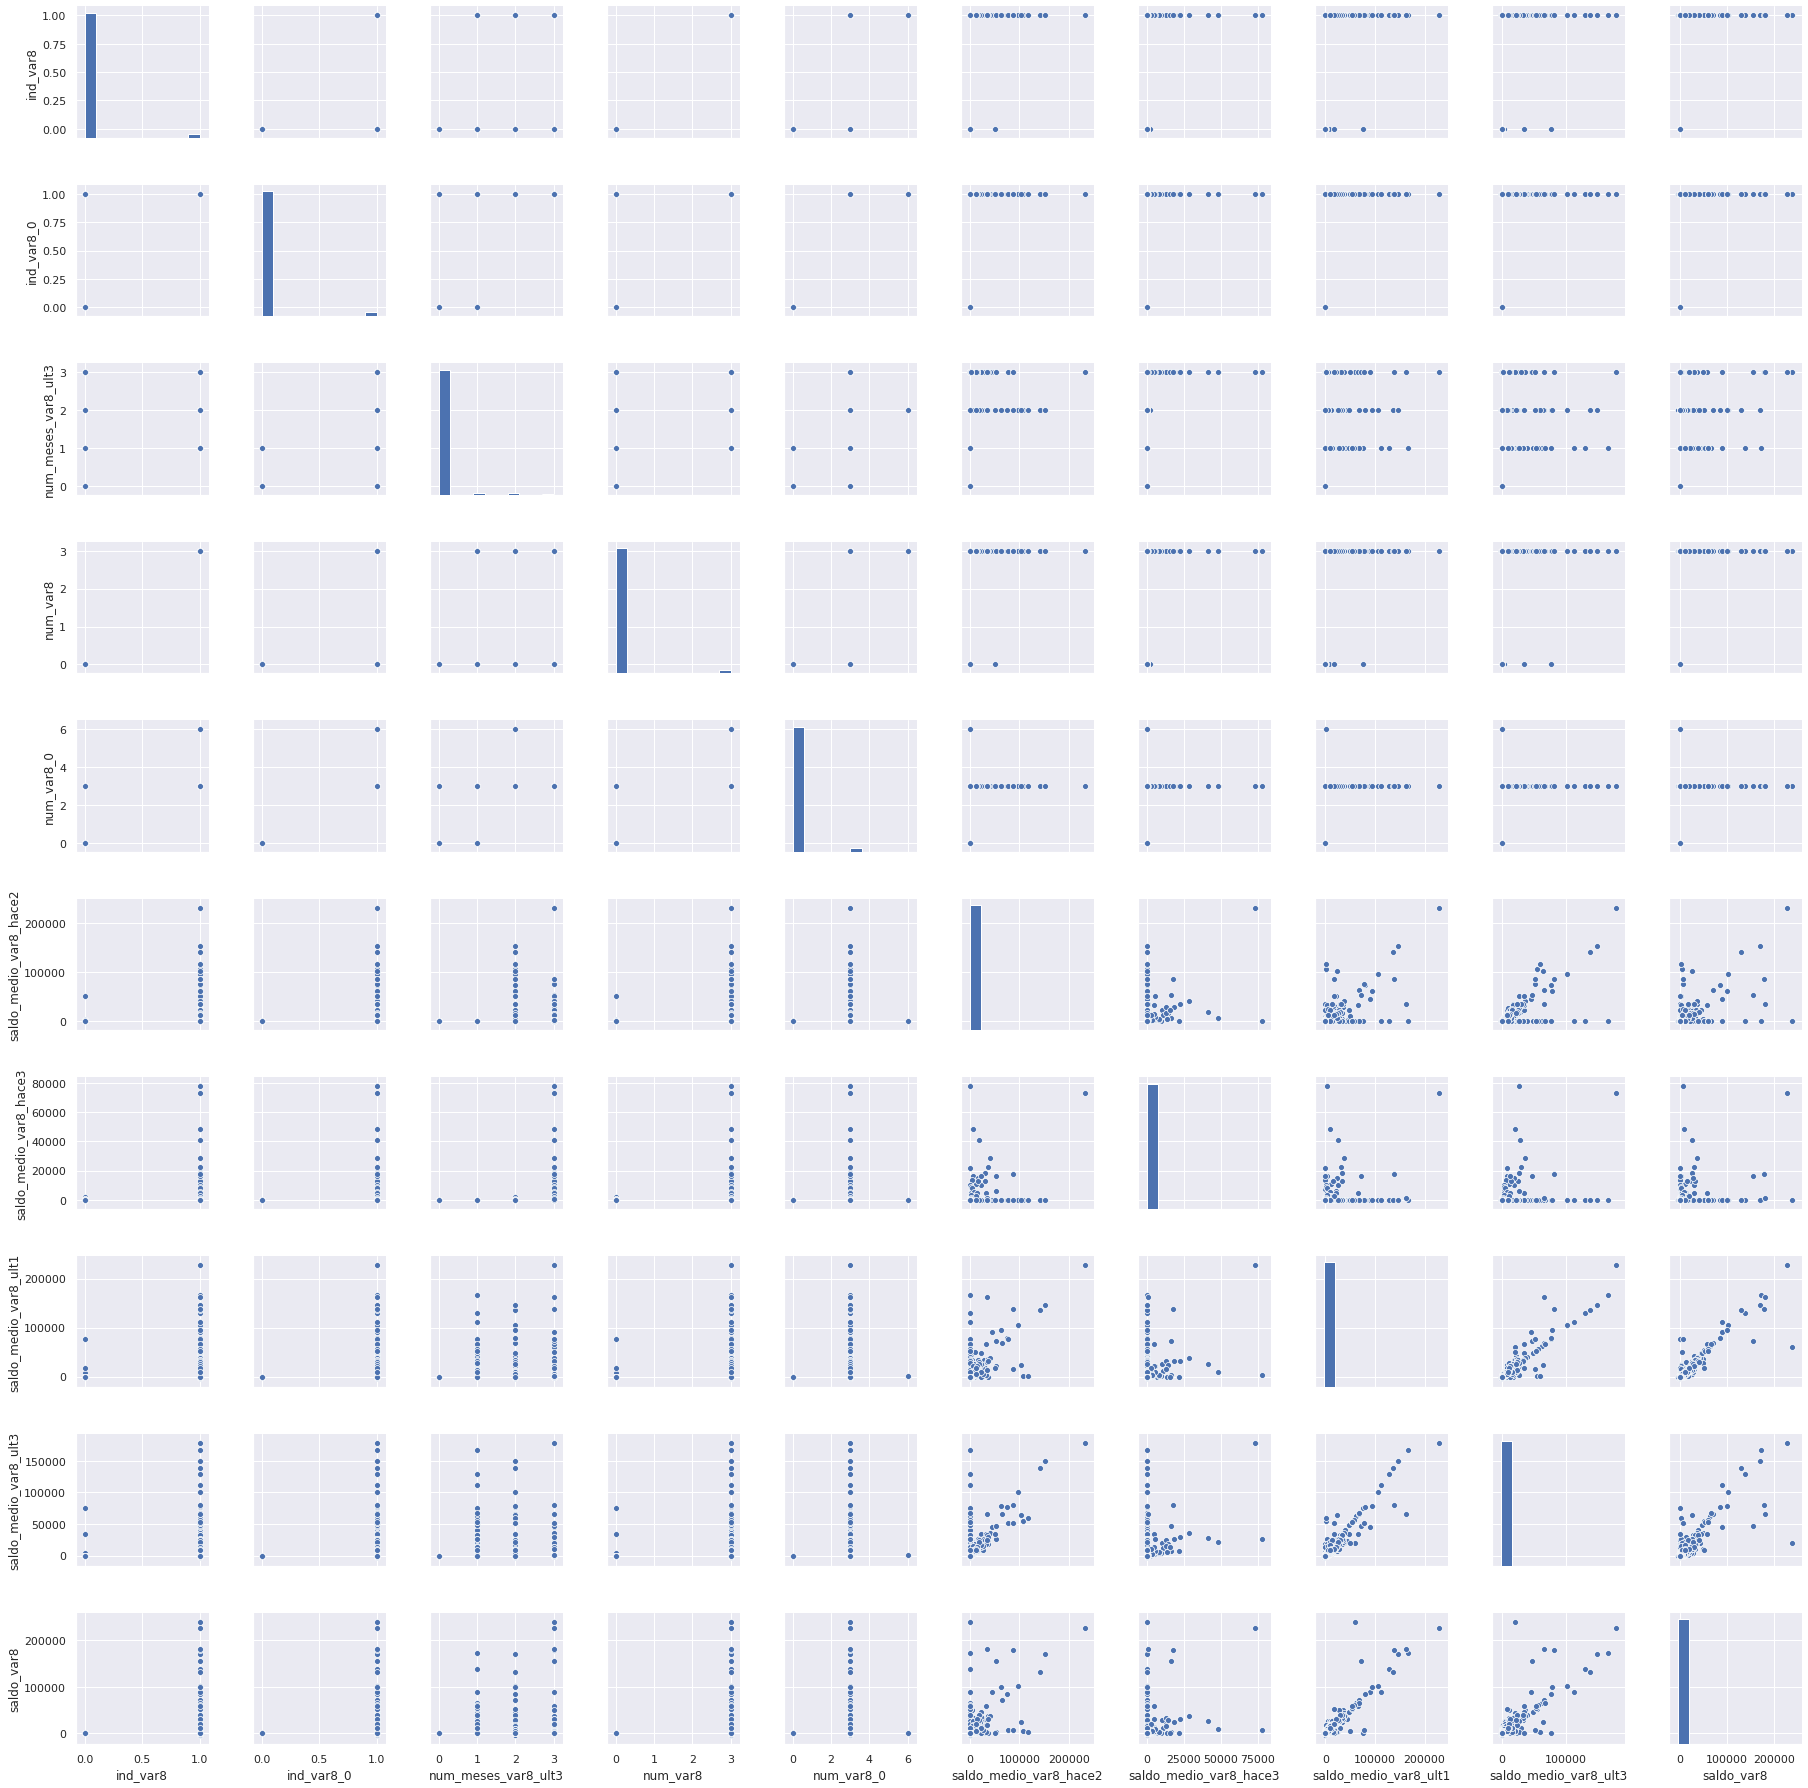

In [18]:
sns.pairplot(train[(grouped.loc[['var8','names']].reset_index())['names'].values]);

Tratar as features dessa forma nos leva à um trabalho cansativo e de muita inferência sobre resultados que não conhecemos, sendo assim, vamos usar uma metodologia baseada na importância dessas mesmas features.

## Seleção das features

### Remoção das features com baixa variância

In [11]:
from collections import defaultdict
columns_by_thresholds = defaultdict(list)

var_thresholds = np.linspace(0.0, 1.0, 11)

# pegando features com variância até < 1.0
remove = {}

for thresholds in var_thresholds:
    remove = []
    for col in [x for x in train.columns if x!='TARGET']:
        if train[col].var() < thresholds:
            remove.append(col)
        columns_by_thresholds["{0:.1f}".format(thresholds)] = remove

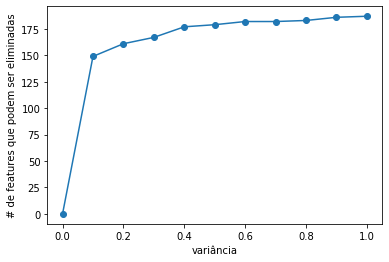

In [12]:
plt.plot([float(i) for i in columns_by_thresholds.keys()], [len(x) for x in columns_by_thresholds.values()], '-o')
plt.xlabel('variância')
plt.ylabel('# de features que podem ser eliminadas');

Assim, pegando as features com $\sigma^2 (feature)\le 0.5$ já removemos algumas features que não impactarão nosso modelo

In [13]:
columns_best = list(set(train.columns) - set(columns_by_thresholds['0.5']))

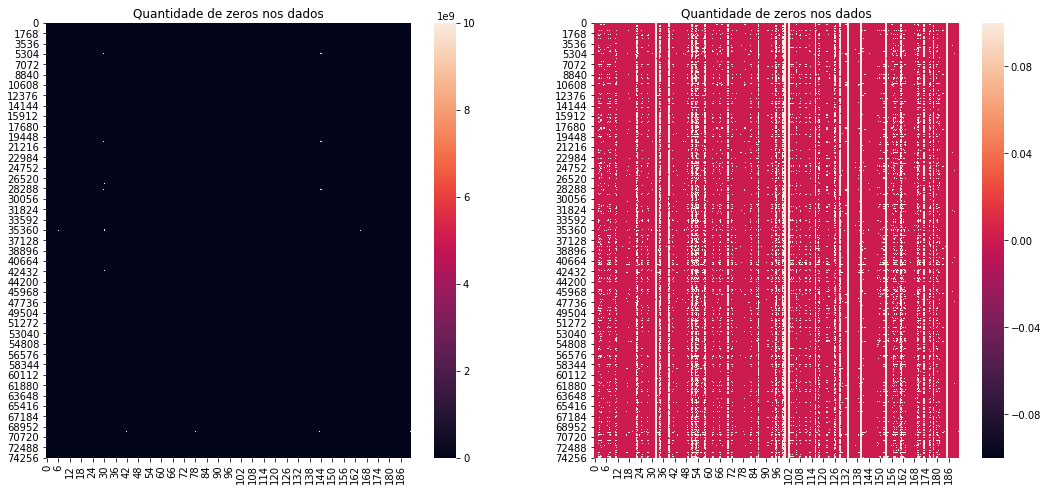

In [14]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
sns.heatmap(train[columns_best].values, ax=axes[0])
axes[0].set_title('Quantidade de zeros nos dados')
sns.heatmap((train[columns_best] + 1).apply(np.log10).values, ax=axes[1])
axes[1].set_title('Quantidade de zeros nos dados');

In [15]:
# removendo as colunas com variancia menor que 0.2
remove_lower_variance = columns_by_thresholds['0.2']
train.drop(remove_lower_variance, axis=1, inplace=True)
test.drop(remove_lower_variance, axis=1, inplace=True)

In [16]:
# removendo colunas duplicadas
remove_duplicate = []

cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove_duplicate.append(cols[j])

train.drop(remove_duplicate, axis=1, inplace=True)
test.drop(remove_duplicate, axis=1, inplace=True)

### Modelo base

Com a remoção das features **menos importantes**, podemos criar um modelo *baseline* que pode nos auxiliar em tratar as features mais importantes

In [17]:
# quantidade de features restantes
train.shape[1]

198

In [18]:
# split data into train and test
test_id = test.ID
test = test.drop(["ID"],axis=1)

In [19]:
test

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.100000
1,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.720000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.950000
3,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.610000
4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.730000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75813,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40243.200000
75814,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146961.300000
75815,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167299.770000
75816,2,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016


In [125]:
X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1729)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60816, 196) (15204, 196) (60816,) (15204,)


In [126]:
## # Feature selection
clf = ExtraTreesClassifier(random_state=1729, n_jobs=-1)
selector = clf.fit(X_train, y_train)

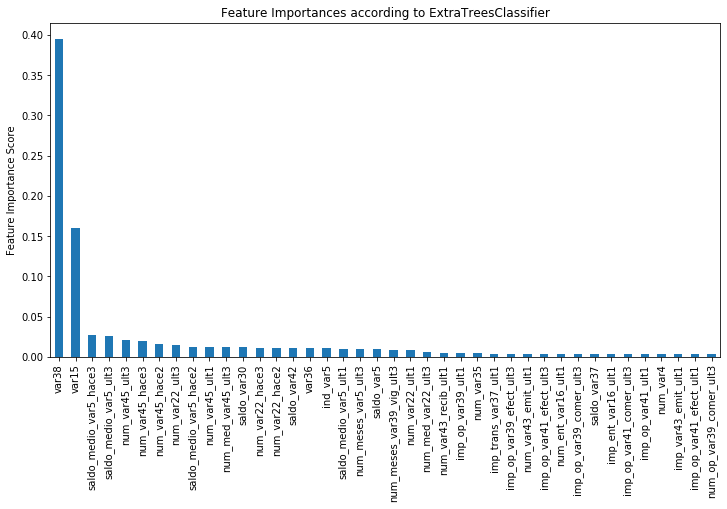

In [127]:
# plot most important features
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.savefig('1.png')
plt.show()

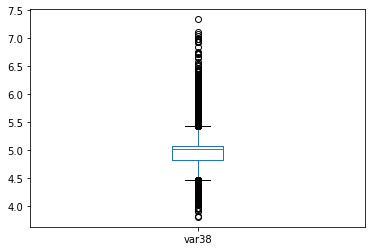

In [128]:
X_train.var38.apply(np.log10).plot.box()

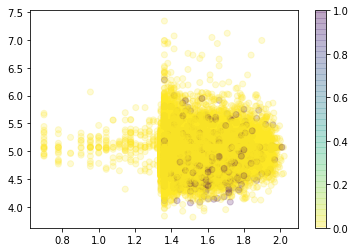

In [129]:
plt.scatter(X_train.var15.apply(np.log10), X_train.var38.apply(np.log10), c=y_train.values, cmap=plt.cm.viridis_r, alpha=0.2)
plt.colorbar();

### Logistic Regression

In [189]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV

In [142]:
X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1729)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45612, 196) (30408, 196) (45612,) (30408,)


In [168]:
parameters_to_tune = {'class_weight':[{0: w} for w in [1, 2, 4, 6, 10]]}

In [190]:
lr = LogisticRegression()

In [169]:
lr_cv = LogisticRegressionCV(cv=5, class_weight=[{1: w} for w in [1, 2, 4, 6, 10]], n_jobs=-1)

In [191]:
clf = GridSearchCV(lr, parameters_to_tune)

In [192]:
clf.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': [{0: 1}, {0: 2}, {0: 4}, {0: 6},
                                          {0: 10}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [193]:
print (clf.best_params_)

{'class_weight': {0: 1}}


In [194]:
y_pred = clf.predict(X_test)

In [195]:
print(classification_report(y_true = y_test.values, y_pred = y_pred, labels=[0,1], target_names=['satisfeito', 'insatisfeito']))

              precision    recall  f1-score   support

  satisfeito       0.96      1.00      0.98     29201
insatisfeito       0.00      0.00      0.00      1207

    accuracy                           0.96     30408
   macro avg       0.48      0.50      0.49     30408
weighted avg       0.92      0.96      0.94     30408



In [223]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

In [197]:
cm

array([[29201,     0],
       [ 1207,     0]])

In [209]:
tn, fp, fn, tp

(29201, 0, 1207, 0)

#### Lucro

Definamos o lucro como sendo o quanto eu consigo alcançar com minha campanha menos o que eu gastei

$$
lucro = TP \times 100 - (TP + FP)\times 10
$$

In [227]:
pred_proba_df = pd.DataFrame(clf.predict_proba(X_test))
threshold_list = np.linspace(0.0, 1.0, 50)

lucro = []

for i in threshold_list:
    #print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    #print('Our testing accuracy is {}'.format(test_accuracy))

    #print(confusion_matrix(y_test, y_test_pred, labels=[0,1]))
    
    conf_matrix = confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1), labels=[0,1] )
    tn, fp, fn, tp = conf_matrix.ravel()
    
    print(i, precision_score(y_test, y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))
    
    lucro.append(tp*100 - (tp + fp)*10)

0.0 0.039693501710076295
0.02040816326530612 0.04688083675756444
0.04081632653061224 0.051538520271817975
0.061224489795918366 0.05457433884683675
0.08163265306122448 0.056359044995408634
0.1020408163265306 0.05874730021598272
0.12244897959183673 0.06170828809265291
0.14285714285714285 0.0671046457062412
0.16326530612244897 0.0681198910081744
0.18367346938775508 0.07082833133253301
0.2040816326530612 0.07315731573157316
0.22448979591836732 0.07792207792207792
0.24489795918367346 0.07838745800671892
0.26530612244897955 0.08292682926829269
0.2857142857142857 0.08433734939759036
0.3061224489795918 0.08243727598566308
0.32653061224489793 0.09497206703910614
0.3469387755102041 0.09803921568627451
0.36734693877551017 0.12280701754385964
0.3877551020408163 0.18518518518518517
0.4081632653061224 0.14285714285714285
0.42857142857142855 0.0
0.44897959183673464 0.0
0.4693877551020408 0.0
0.4897959183673469 0.0
0.5102040816326531 0.0
0.5306122448979591 0.0
0.5510204081632653 0.0
0.5714285714285714

### Gradient Boosting

In [334]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

In [349]:
X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1729)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(57015, 196) (19005, 196) (57015,) (19005,)


In [345]:
clf = GradientBoostingClassifier(random_state=1729).fit(X_train, y_train)

In [353]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

In [350]:
print(classification_report(y_true = y_test.values, y_pred = y_pred, labels=[0,1], target_names=['satisfeito', 'insatisfeito']))

              precision    recall  f1-score   support

  satisfeito       0.96      1.00      0.98     18233
insatisfeito       0.25      0.01      0.01       772

    accuracy                           0.96     19005
   macro avg       0.60      0.50      0.49     19005
weighted avg       0.93      0.96      0.94     19005



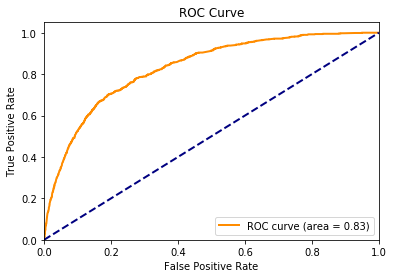

In [372]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, auc, confusion_matrix

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Lucro

Definamos o lucro como sendo o quanto eu consigo alcançar com minha campanha menos o que eu gastei

$$
lucro = TP \times 100 - (TP + FP)\times 10
$$

In [375]:
def predict(clf, X_test, threshold=0.5):
    return clf.predict_proba(X_test)[:, 0] < threshold

def lucro(clf, X_test, y_test, threshold):
    y_pred = predict(clf, X_test, threshold)
   
    tp = (y_pred==1) & (y_test==1)
    fp = (y_pred==1) & (y_test==0)
    
    tp_score = sum(tp * 100)
    pred_score = sum(y_pred)*(-10)
    score = (tp_score + pred_score)
        
    return threshold, tp_score, pred_score, score

In [376]:
lucro_list = []
threshold_list = np.linspace(0.0, 1.0, 50)

for threshold in threshold_list:
    t, _, _, lucro_i = lucro(clf, X_test, y_test, threshold)
    lucro_list.append(lucro_i)

In [381]:
threshold_lucro = pd.DataFrame({'threshold': threshold_list,
                                'lucro': lucro_list})

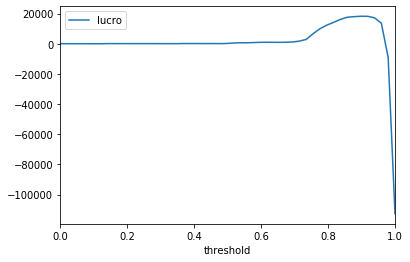

In [383]:
threshold_lucro.plot(x='threshold', y='lucro')

In [388]:
18200 / y_test.shape[0]

0.9576427255985267

In [386]:
threshold_lucro[threshold_lucro.lucro == threshold_lucro.lucro.max()]

,threshold,lucro
44,0.897959,18200


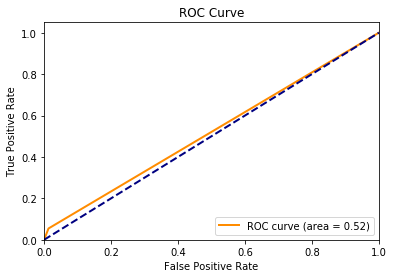

In [333]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Selecionando as melhores features

In [130]:
# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

In [123]:
test_backup = test.copy(deep=True)

TypeError: 'deep' is an invalid keyword argument for copy()

In [131]:
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test = fs.transform(test_backup)

print(X_train.shape, X_test.shape, test.shape)

## # Train Model
# classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=110, njobs=-1, max_depth = 4, \
                           seed=1729)

(60816, 23) (15204, 23) (75818, 23)


In [132]:
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False, 
           eval_set=[(X_test, y_test)])

TypeError: fit() got an unexpected keyword argument 'scale_pos_weight'

In [104]:
from sklearn.metrics import classification_report

#y_pred = m2_xgb.predict(X_test)
y_pred = selector.predict(X_test)

print(classification_report(y_true = y_test.values, y_pred = y_pred, labels=[0,1], target_names=['satisfeito', 'insatisfeito']))

              precision    recall  f1-score   support

  satisfeito       0.96      0.99      0.97     14583
insatisfeito       0.13      0.05      0.07       621

    accuracy                           0.95     15204
   macro avg       0.55      0.52      0.52     15204
weighted avg       0.93      0.95      0.94     15204



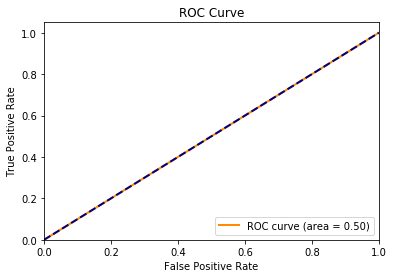

In [181]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [186]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

In [187]:
cm

array([[29201,     0],
       [ 1207,     0]])

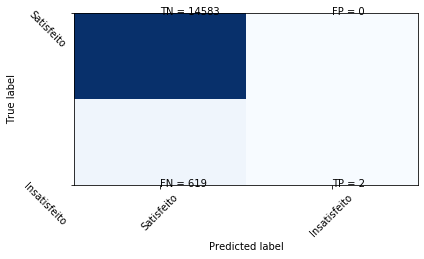

In [118]:
plt.clf()

plt.imshow(cm, interpolation=None, cmap=plt.cm.Blues)
classNames = ['Satisfeito','Insatisfeito']


plt.ylabel('True label')
plt.xlabel('Predicted label')

tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames, rotation=-45)
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i+0.01, str(s[i][j])+" = "+str(cm[i][j]))

plt.tight_layout()
plt.show()

In [197]:
tn, fp, fn, tp

(14583, 0, 619, 2)

In [195]:
pd.DataFrame({'test': y_test, 'pred': y_pred})

,test,pred
4200,0,0
75635,0,0
4806,0,0
63434,0,0
5222,0,0
...,...,...
50025,0,0
33933,0,0
52023,0,0
45715,0,0


## Nao funcionou

### Recursive Feature Elimination

Usando o Gradient Boosting Trees, conseguimos um modelo base que já tem uma boa métrica definida. 
Vamos observar uma outra seleção de features, baseada na eliminação de features, recursivamente, 
observando o score da predição

In [99]:
X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET
test = test_backup

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1729)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60816, 196) (15204, 196) (60816,) (15204,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import RFECV

estimator = RandomForestClassifier()
selector = RFECV(estimator=estimator, step=1, cv=KFold(3),
              scoring='accuracy')

In [97]:
selector = selector.fit(X_train, y_train)

In [100]:
X_train_rfe = selector.transform(X_train)
X_test_rfe = selector.transform(X_test)

test = selector.transform(test)

In [101]:
y_pred = selector.predict(X_test)

In [106]:
selector.n_features_

24

In [228]:
print(classification_report(y_true = y_test.values, y_pred = y_pred, 
                            labels=[0,1], target_names=['satisfeito', 'insatisfeito']))

              precision    recall  f1-score   support

  satisfeito       0.96      1.00      0.98     29201
insatisfeito       0.00      0.00      0.00      1207

    accuracy                           0.96     30408
   macro avg       0.48      0.50      0.49     30408
weighted avg       0.92      0.96      0.94     30408



In [107]:
roc_auc_score(y_test, y_pred)

0.5194407756235256

In [185]:
print(classification_report(y_test, y_pred, target_names=['satisfeito', 'insatisfeito']))

              precision    recall  f1-score   support

  satisfeito       0.96      1.00      0.98     29201
insatisfeito       0.00      0.00      0.00      1207

    accuracy                           0.96     30408
   macro avg       0.48      0.50      0.49     30408
weighted avg       0.92      0.96      0.94     30408



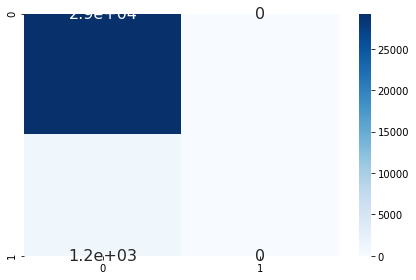

In [184]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

sns.heatmap(confusion_matrix(y_test, y_pred, labels=[0,1]), annot=True,
            annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.tight_layout()